# ARIMA PREDICTION

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import missingno as msno
import os, warnings, gc
import scipy.stats as stats
import random
seed = 4092
random.seed(seed)
np.random.seed(seed)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings('ignore')

#Time series libraries
from scipy import stats
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import pacf, plot_acf,plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import  ARIMA
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
%matplotlib inline

### LOADING AND VERIFYING DATA:

In [77]:
df = pd.read_csv(os.getcwd()+"/pre_processing/dataset_traite.csv", sep=',',index_col=['DateTime'])
df.index = pd.to_datetime(df.index)
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [79]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [80]:
#print(f"The total sum of the duplicated entries is: {df.duplicated().sum()}")
#df = df.drop_duplicates(keep = 'first')

#print('Duplicate check shows the shape of duplicated entries is', df[df.duplicated()].shape)

In [81]:
df.shape

(2075259, 7)

### CORRELATION BETWEEN LAG VARIABLES AND OUTPUT VARIABLE (GLOBAL_ACTIVE_POWER):

### Lets resample our dataset day by day

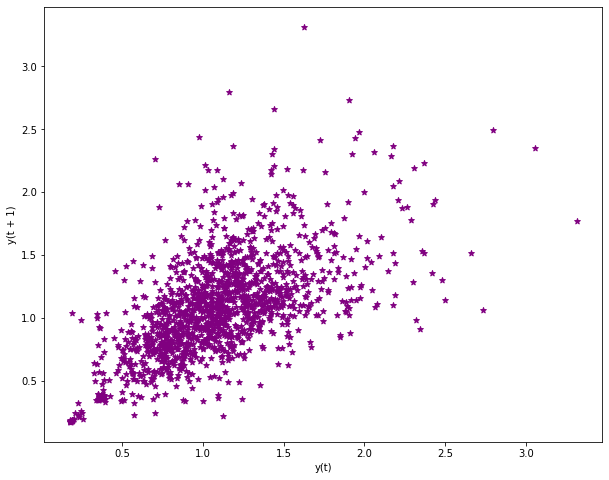

In [82]:
lagplot_data = df['Global_active_power'].resample('D').mean()
plt.figure(figsize = (10,8))
lagplot = lag_plot(lagplot_data, c = 'purple', marker = '*')
plt.show()

#### The lag plot shows the variables at time t on the x axis, and variables at time t+1 on the y axis.
#### So if the lagplot shows some form of correlation, like a line or a curve, we can say that the plot shows some form of correlation betwwen present and future time for the variables of the dataset.
#### Here we plotted only Global Active Power, so we can say that the value of Global active power at t+1 is correlated to the value at t, therefor it might be predictable

In [83]:
lagplot_data_df = pd.concat([lagplot_data.shift(-1), lagplot_data], axis = 1)
lagplot_data_df.columns = ['Global_active_power(t)', 'Global_active_power(t+1)']
lagplot_data_corr = lagplot_data_df.corr()
lagplot_data_corr

,Global_active_power(t),Global_active_power(t+1)
Global_active_power(t),1.000000,0.609853
Global_active_power(t+1),0.609853,1.000000


#### The correlation matrix above that global active power at time t and at tiem t+1 are correlated at 61%

### Lets resample the dataset again but week by week

In [84]:
lagplot_data1 = df['Global_active_power'].resample('W').mean()

#### Lets plot an autocorrelation plot of the data per week

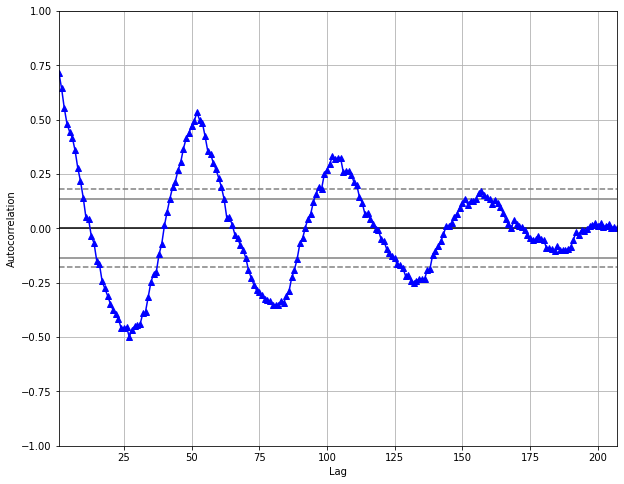

In [85]:
plt.figure(figsize = (10,8))
lagplot1 = autocorrelation_plot(lagplot_data1, c = 'blue', marker = '^')
lagplot1.plot(title = 'Autocorrelation Plot of the Data resampled over Hour')
plt.show()